# Projet statistique descriptive 



In [1]:
%reload_ext autoreload
%autoreload 2

# module
import sys
sys.path.append("../")
from src import * 

# chemin vers la donnee 
data_dir = 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive/'
filelist = glob.glob(data_dir + '*.h5')
filelist

['C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03_dask.h5']

In [2]:
from tabata import Opset
#première visualisation brut de la données 

# Première visualisation brut de la données 
La visualisation des graphes nous à permis dans un premier temps de constater des anomalies dans les données et de supprimer ces données pour la suite de nos analyse.En effet ces données dites anormales représentent des mesures ou l'avions n'à pas décollé (sûrement des tests au sols) donc il est légitimes de les supprimer quand on s'intéresse aux comportements de l'avion en vol.

In [3]:
df_opset1=Opset('C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01.h5')
df_opset2=Opset('C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02.h5')
df_opset3=Opset('C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03.h5')

In [4]:
df_opset1

OPSET 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\Aircraft_01.h5' de 1002 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT [ft]
        phase surlignée   : phase   = None

In [5]:
df_opset1.plot()

In [6]:
type(df_opset2)

tabata.opset.Opset

In [7]:
df_opset2.plot()

In [8]:
df_opset3.plot()

## Creation d'une fonction sur les dataframes pour éliminer les records anormaux
On utilise l'avantage de Dask qui permet de paralléliser sur les dataframes.
Le but de la fonction eliminate_records() est de vérifier la différence entre l'altitude minimum et maximum est d'au plus 15000 ft si c'est le cas alors elle renvoit False et True sinon.



In [9]:
def eliminate_records(df):
    
    alt_min=df['ALT [ft]'].min()
    alt_max=df['ALT [ft]'].max()
    alt_range=alt_max-alt_min
    bol=False
    
    if alt_range<15000:
        bol=True
    return bol
    
    

In [10]:
#on cree notre dataframe avec DASK
ddf1 = lire_hdf_dask(filelist[0], repertoire= data_dir)
#on récupère une liste de booleen où chaque composante fait reférance à une partition 
I = ddf1.map_partitions(lambda df: eliminate_records(df)).compute()
#on sélectione dans un nouveau dataframe les partitions qui ne sont pas anormales 
DDF1=ddf1.partitions[I==False]
# on normalise toute les données excepté les variables booleen 
ddf_norm1 = DDF1.map_partitions(lambda df : normalize(df))

ddf2 = lire_hdf_dask(filelist[2], repertoire= data_dir)
I = ddf2.map_partitions(lambda df: eliminate_records(df)).compute()
DDF2=ddf2.partitions[I==False]
ddf_norm2 = DDF2.map_partitions(lambda df : normalize(df))

ddf3 = lire_hdf_dask(filelist[3], repertoire= data_dir)
I = ddf3.map_partitions(lambda df: eliminate_records(df)).compute()
DDF3=ddf3.partitions[I==False]
ddf_norm3 = DDF3.map_partitions(lambda df : normalize(df))

C:\Users\felix\PycharmProjects\pythonProject1\projet_lacaille\stats_descriptive_project\notebooks\..\src\manipulate_dataframe.py:19: RuntimeWarning:

invalid value encountered in divide

C:\Users\felix\PycharmProjects\pythonProject1\projet_lacaille\stats_descriptive_project\notebooks\..\src\manipulate_dataframe.py:19: RuntimeWarning:

invalid value encountered in divide

C:\Users\felix\PycharmProjects\pythonProject1\projet_lacaille\stats_descriptive_project\notebooks\..\src\manipulate_dataframe.py:19: RuntimeWarning:

invalid value encountered in divide



In [11]:
ddf_norm2.head()

,ALT,EGT_1,EGT_2,FMV_1,FMV_2,HPTACC_1,HPTACC_2,M,N1_1,N1_2,...,VIB_AN1_1,VIB_AN1_2,VIB_AN2_1,VIB_AN2_2,VIB_BN1_1,VIB_BN1_2,VIB_BN2_1,VIB_BN2_2,VSV_1,VSV_2
record_00,,,,,,,,,,,,,,,,,,,,,
0,-1.134103,-3.447952,-3.667389,-2.28672,-2.364025,-1.128226,-1.261854,-1.339298,-1.854991,-1.873735,...,-1.22466,-1.070851,-1.455161,-0.995082,-1.3565,-1.18976,-1.749496,-1.453541,1.376408,1.386277
1,-1.134103,-3.447952,-3.667389,-2.28672,-2.364025,-1.128226,-1.261854,-1.339298,-1.854991,-1.873735,...,-1.22466,-1.070851,-1.455161,-0.995082,-1.3565,-1.18976,-1.749496,-1.453541,1.376408,1.386277
2,-1.134103,-3.447952,-3.674029,-2.28672,-2.364025,-1.126343,-1.261854,-1.339298,-1.854991,-1.873735,...,-1.22466,-1.070851,-1.455161,-0.995082,-1.3565,-1.18976,-1.749496,-1.453541,1.376408,1.390019
3,-1.134103,-3.447952,-3.667389,-2.28672,-2.364025,-1.128226,-1.259411,-1.339298,-1.854991,-1.873735,...,-1.22466,-1.070851,-1.455161,-0.995082,-1.3565,-1.18976,-1.749496,-1.453541,1.376408,1.386277
4,-1.134103,-3.447952,-3.667389,-2.28672,-2.364025,-1.128226,-1.261854,-1.339298,-1.854991,-1.873735,...,-1.22466,-1.070851,-1.455161,-0.995082,-1.3565,-1.18976,-1.749496,-1.453541,1.376408,1.386277


# Etude de la relation entre monte et EGT 
-On cherche à trouver des relations entre EGT max et la vitesse de monte par exemple 



Il va falloir peut être modifier la fonction deriv_glissante lorsque qu'on passera à l'analyse de chaque record 

In [48]:
def deriv_glissante(df):
    
    #on cree une fonction qui prend un data frame qui l'augment de la valeur dy et qui renvoit  un nouveau dataframe contenant que le monté 
    #ATTENTION LA FONCTION PRENDS EN ENTREE DES DONNEES NORMALISEE
    
    dy=np.zeros(len(df))
    
    #on fait une moyenne glissante pour éviter d'être sensible aux bruit. En effet pour le cacul de dérivée le bruit 
    #fausse trés rapidement les données
    y = df['ALT'].rolling(window = 20).mean()
    I = range(y.index[0], y.index[-1],20)
    #calcul de la derivée
    dy[0:len(I)-1] = y[I[1:]].values- y[I[:-1]].values
    #creation d'une nouvelle colonne dans le dataframe
    df['dy']=dy
    #on selectionne le dataframe où les dérivées sont plus grande que 0.01 (la montée)
    df_monte=df[df['dy']>0.01]
    I4=np.zeros(len(df_monte))
    #on verifie qu' avec un shift des données on retombe bien sur les mêmes indices cela permet d'éviter 
    # de prendre en compte des valeurs qui ne serait pas dans la phase de la montée 
    #Attention cette façon de faire est lié aux cas d'un vol d'avion (l'hypothèse admise est que l'avion ne monte qu'une fois)
    #Et s'il existe plus de 6 données anormale consécutives alors elles seront prise en compte 
    
    I4[5:]=df_monte.index[5:]==(df_monte.index+5)[:-5]
    I4[:5]=1
    df_monte2=df_monte[I4==1]
    


    return df_monte2

In [49]:
_VOL=10
DF_monte=ddf_norm1.map_partitions(lambda df:deriv_glissante(df))
DF_monte.partitions[_VOL].compute()

,ALT,EGT_1,EGT_2,FMV_1,FMV_2,HPTACC_1,HPTACC_2,M,N1_1,N1_2,...,VIB_AN1_2,VIB_AN2_1,VIB_AN2_2,VIB_BN1_1,VIB_BN1_2,VIB_BN2_1,VIB_BN2_2,VSV_1,VSV_2,dy
record_101,,,,,,,,,,,,,,,,,,,,,
34,-1.497996,-3.525778,-3.787406,-2.644857,-2.726506,-1.458621,-1.543392,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.052481
35,-1.497996,-3.525778,-3.787406,-2.644857,-2.726506,-1.458621,-1.543392,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.053005
36,-1.497996,-3.525778,-3.787406,-2.644857,-2.726506,-1.460044,-1.543392,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.055372
37,-1.497996,-3.525778,-3.787406,-2.644857,-2.726506,-1.456962,-1.541692,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.054639
38,-1.497996,-3.525778,-3.787406,-2.644857,-2.726506,-1.456962,-1.541692,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.081540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,-1.497996,-3.531925,-3.793829,-2.644857,-2.726506,-1.458621,-1.544848,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.027882
92,-1.497996,-3.531925,-3.787406,-2.644857,-2.726506,-1.456962,-1.541692,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.036160
93,-1.497996,-3.531925,-3.793829,-2.644857,-2.726506,-1.456962,-1.543392,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.021788


7278

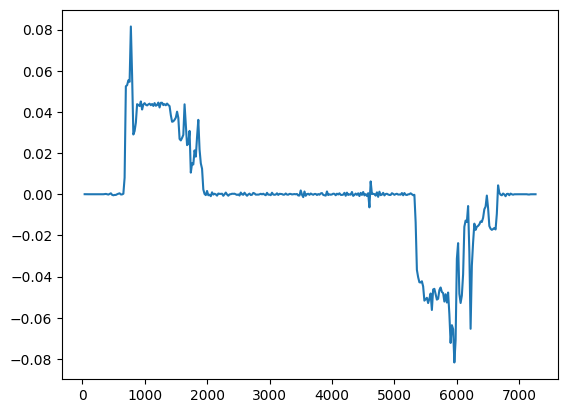

In [15]:
df=ddf_norm1.partitions[10].compute()
y = df['ALT'].rolling(window = 20).mean()
I = range(y.index[0], y.index[-1],20)
dy = y[I[1:]].values- y[I[:-1]].values
plt.plot(I[1:], dy)
len(y)

In [63]:
df12=ddf_norm1.partitions[100].compute()

df_monte2=deriv_glissante(df12)


#plt.plot(df12['EGT_1'][I_monte])


#duree de la monte
duree=len(df_monte2)*20
#Indice monte
I_monte=df_monte2.index*20
#calcul de l'egt max pour chaque moteur pendant la monté
EGT_max_monte1=df['EGT_1'][I_monte].max()
EGT_max_monte2=df['EGT_2'][I_monte].max()
EGT_max_monte=max(EGT_max_monte1,EGT_max_monte2)
df12['dy'].max()

0.07834940808745561

peut paralléliser avec dask 

In [67]:
duree11=[]
EGT_max_monte1=[]
EGT_mean_monte1=[]
Vitesse_max=[]
I=[]
for i in range (0,990,10):
    I.append(i)
    df11=ddf_norm1.partitions[i].compute()
    #df22=ddf_norm2.partitions[i].compute()
    #df22=ddf_norm3.partitions[i].compute()
    df_monte11=deriv_glissante(df11)
    #[df_monte22]=deriv_glissante(df22)
    #[df_monte33]=deriv_glissante(df33)
    
    duree11.append(len(df_monte11)*20)
    #duree22=len(df_monte22)*20
    #duree33=len(df_monte33)*20

    #Indice monte
    I_monte11=df_monte11.index*20
    #I_monte22=df_monte22.index*20
    #I_monte33=df_monte33.index*20
    #calcul de la vittesse max pendant la monte 
    Vitesse_max.append(df_monte11['dy'].mean())
    #calcul de l'egt max pour chaque moteur pendant la monté
    
    EGT_max_monte11=df11['EGT_1'][I_monte11].max()
    EGT_max_monte21=df11['EGT_2'][I_monte11].max()
    
    #EGT_mean_monte11=df['EGT_1'][I_monte11].mean()
    #EGT_mean_monte21=df['EGT_2'][I_monte11].mean()   
    #EGT_max_monte12=df['EGT_1'][I_monte22].max()
    #EGT_max_monte22=df['EGT_2'][I_monte22].max()
    
    #EGT_max_monte13=df['EGT_1'][I_monte33].max()
    #EGT_max_monte23=df['EGT_2'][I_monte33].max()
    #EGT_mean_monte1.append(EGT_max_monte11)
    EGT_max_monte1.append(max(EGT_max_monte11,EGT_max_monte21))
    #EGT_max_monte2.append(max(EGT_max_monte12,EGT_max_monte22))    
    #EGT_max_monte3.append(max(EGT_max_monte13,EGT_max_monte23))    


In [68]:
Vitesse_max

[0.04366583307864201,
 0.03779479610148353,
 0.03754643263764461,
 0.04786996393683873,
 0.047344553924291176,
 0.0453796904015833,
 0.03936464550060502,
 0.045799715548892665,
 0.049018822472354194,
 0.04239698160041652,
 0.04915173138395065,
 0.04633242668578033,
 0.045343880535642325,
 0.062225840544981856,
 0.04823194141009554,
 0.049950867000539086,
 0.04279280360301187,
 0.06357009743241049,
 0.0449316414756789,
 0.051846776823498926,
 0.0472675681450572,
 0.04473526477375353,
 0.043787359987979384,
 0.04319307382287909,
 0.05358540981039035,
 0.039865932628931434,
 0.04073775647153104,
 0.048669745177632284,
 0.043639909854825756,
 0.03675402857734868,
 0.04077790830474932,
 0.039463723770688734,
 0.04697253828378281,
 0.053898374125197775,
 0.04221542096329617,
 0.054313802851619575,
 0.04279534948665659,
 0.04798885508131773,
 0.045745653995608905,
 0.07304169105543762,
 0.04311086588902397,
 0.05712949918501404,
 0.04367146395927131,
 0.04362155249086913,
 0.03807406265350033

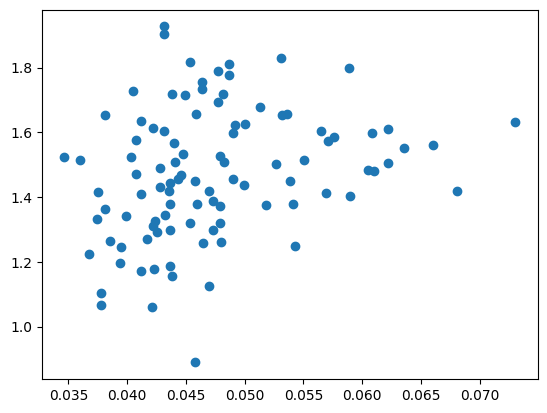

In [69]:
plt.scatter(Vitesse_max,EGT_max_monte1)

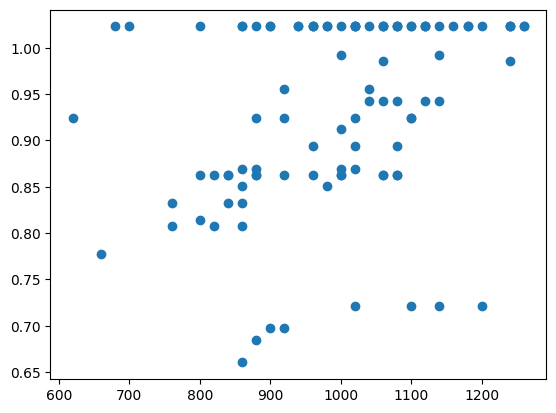

In [22]:
plt.scatter(duree11,EGT_mean_monte1)

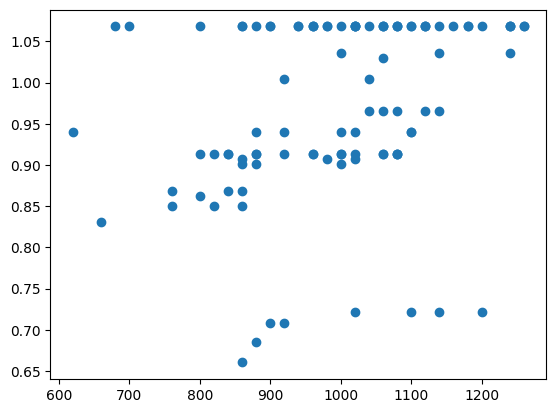

In [18]:
plt.scatter(duree11,EGT_max_monte1)

In [20]:
EGT_max_monte1

[1.0680639905784488,
 1.0680639905784488,
 0.965302722206326,
 1.0680639905784488,
 1.0680639905784488,
 1.0680639905784488,
 1.0680639905784488,
 0.9396124051132954,
 1.0680639905784488,
 1.0680639905784488,
 1.0680639905784488,
 0.9139220880202649,
 1.0680639905784488,
 0.8496962952876875,
 0.9010769294737493,
 0.7083995512760193,
 0.9396124051132954,
 0.8689640331074606,
 1.0038381978458721,
 1.0038381978458721,
 0.9396124051132954,
 1.0680639905784488,
 0.965302722206326,
 1.0680639905784488,
 0.9010769294737493,
 0.7218647042785147,
 1.0680639905784488,
 0.9139220880202649,
 1.0680639905784488,
 1.0680639905784488,
 1.0680639905784488,
 1.0680639905784488,
 1.0680639905784488,
 1.0680639905784488,
 1.0680639905784488,
 0.8689640331074606,
 1.0680639905784488,
 0.9139220880202649,
 1.0680639905784488,
 0.8304285574679144,
 1.0680639905784488,
 0.9139220880202649,
 1.0680639905784488,
 0.9396124051132954,
 1.0680639905784488,
 1.0680639905784488,
 1.03595109421216,
 0.91392208802026

In [26]:
from sklearn.cluster import KMeans

In [39]:
Array2D[:,1]

array([1060., 1240., 1060.,  940.,  980., 1020., 1200.,  620.,  900.,
       1080.,  900., 1080.,  940.,  860.,  880.,  920., 1100.,  760.,
       1040.,  920., 1020., 1000., 1080.,  960.,  860., 1100., 1020.,
       1000., 1040., 1260., 1180., 1140.,  960.,  860., 1100.,  860.,
       1120.,  960.,  980.,  660., 1060.,  840., 1020., 1100., 1240.,
        800., 1240., 1060.,  980.,  860., 1000.,  880.,  920.,  680.,
       1240.,  820., 1060.,  960., 1160.,  960.,  860.,  900., 1080.,
       1040.,  820., 1020.,  800.,  800., 1200., 1100.,  880., 1120.,
       1140., 1180., 1140., 1080., 1120.,  760., 1060., 1080.,  880.,
       1060.,  700., 1000., 1140., 1260.,  920., 1120.,  880.,  880.,
       1000.,  860., 1000.,  840., 1020., 1020.,  840., 1020., 1080.])

Text(0, 0.5, 'duree')

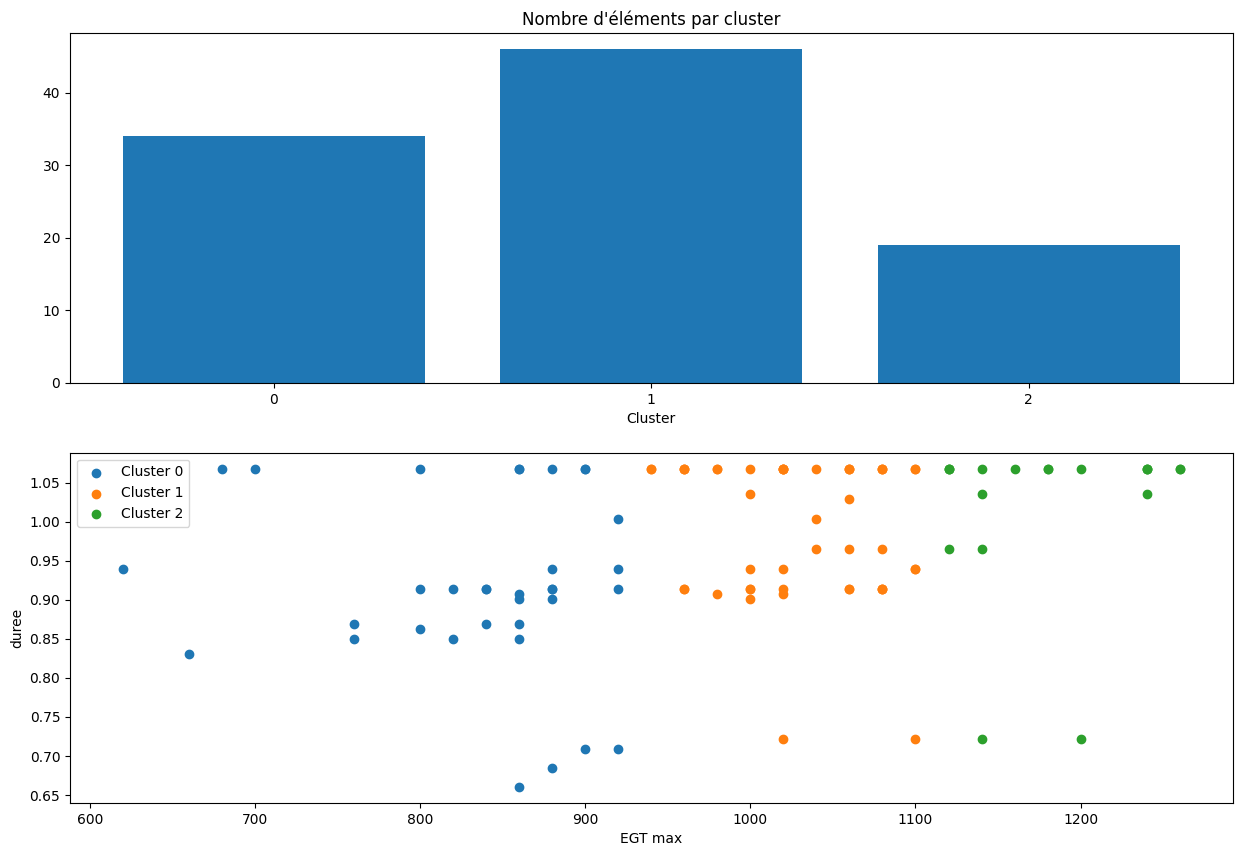

In [36]:
K = 3
Array2D=np.column_stack((EGT_max_monte1,duree11))
km = KMeans(n_clusters=K, n_init=10)
labels = km.fit_predict(Array2D)
cnt = np.bincount(labels)

fig,ax = plt.subplots( 2, figsize=(15,10))

ax[0].bar(np.arange(K), cnt, tick_label=np.arange(K))
ax[0].set_title('Nombre d\'éléments par cluster')
ax[0].set_xlabel('Cluster')
for c in range(km.n_clusters):
    ax[1].scatter(Array2D[labels == c, 1], Array2D[labels == c, 0], label="Cluster "+str(c))
ax[1].legend()
ax[1].set_xlabel('duree')
ax[1].set_ylabel('EGT max')

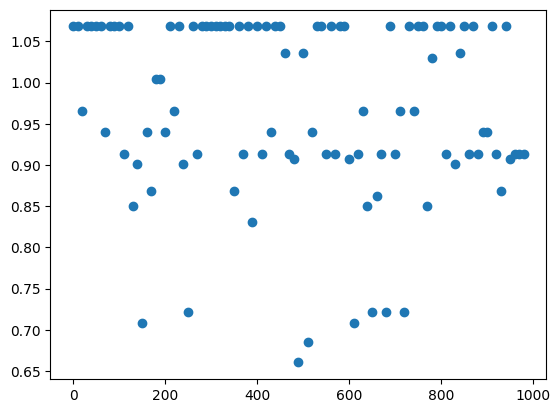

In [19]:
plt.scatter(I,EGT_max_monte1)

# Suite de l'analyse Corelation et ACP en montee

In [ ]:
# peut on prédire l'egt en fonction des température et des autre valeurs 

In [ ]:
#peut on analyser les données manquantes et peut être apporter un corectif  